### <b>3분 만에 전이 학습(Transfer Learning)을 활용한 인공지능 서비스 만들기</b>

* 본 프로젝트에서는 세 가지 기능을 합쳐서 순식간에 상용 인공지능 서비스를 제작합니다.
    1. 이미지 크롤링(image crawling) 혹은 크롤링 라이브러리
    2. 전이 학습(transfer learning)
    3. 웹 API 개발
* 이 프로젝트에서 만들어 볼 것은 <b>마동석/김종국/이병헌</b> 분류기(classifier)입니다.
* 단 <b>3분</b> 만에 인공지능 개발의 전체 과정을 진행합니다.
    * 데이터 수집/정제
    * 인공지능 모델 학습
    * 학습된 모델 배포
* 한글 폰트 설치 이후에 <b>[런타임] - [런타임 다시 시작]</b>을 수행해야 합니다.

In [ ]:
# 한글 폰트 설치하기 (꼭! 설치가 완료되면 [런타임 다시 시작]을 누르고 다시 실행하기)
!apt install fonts-nanum -y

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정하기
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
matplotlib.font_manager._rebuild()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
# 필요한 라이브러리 설치하기
!git clone https://github.com/ndb796/bing_image_downloader

Cloning into 'bing_image_downloader'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 86 (delta 38), reused 46 (delta 16), pack-reused 0
Unpacking objects: 100% (86/86), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### <b>1. 이미지 크롤링을 활용한 학습 이미지 수집</b>

* 수집한 이미지를 저장하기 위한 폴더를 생성하고, 필요한 함수를 정의합니다.

In [ ]:
import os
import shutil
from bing_image_downloader.bing_image_downloader import downloader


directory_list = [
    './drive/MyDrive/custom_dataset/train/',
    './drive/MyDrive/custom_dataset/test/',
]

# 초기 디렉토리 만들기
for directory in directory_list:
    if not os.path.isdir(directory):
        os.makedirs(directory)

# 수집한 이미지를 학습 데이터와 평가 데이터로 구분하는 함수
def dataset_split(query, train_cnt):
    # 학습 및 평가 데이터셋 디렉토리 만들기
    for directory in directory_list:
        if not os.path.isdir(directory + '/' + query):
            os.makedirs(directory + '/' + query)
    # 학습 및 평가 데이터셋 준비하기
    cnt = 0
    for file_name in os.listdir(query):
        if cnt < train_cnt:
            print(f'[Train Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './drive/MyDrive/custom_dataset/train/' + query + '/' + file_name)
        else:
            print(f'[Test Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './drive/MyDrive/custom_dataset/test/' + query + '/' + file_name)
        cnt += 1
    shutil.rmtree(query)

* <b>다금바리</b> 이미지 크롤링을 진행하고 데이터셋을 구축합니다.

In [ ]:
query = '다금바리'
downloader.download(query, limit=0,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 0)

* <b>능성어</b> 이미지 크롤링을 진행하고 데이터셋을 구축합니다.

In [ ]:
query = '능성어'
downloader.download(query, limit=0,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 0)

* <b>물고기</b> 이미지 크롤링을 진행하고 데이터셋을 구축합니다.

In [ ]:
query = '물고기'
downloader.download(query, limit=0,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 0)

#### <b>2. PyTorch를 이용한 전이 학습(Transfer Learning)</b>

* 전이 학습(transfer learning)의 동작 과정을 간략화한 것은 다음과 같습니다.

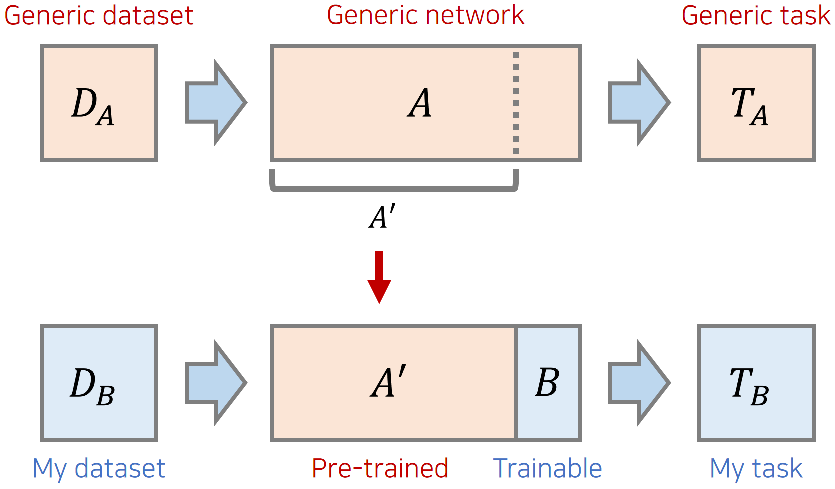

* 학습을 위해 필요한 라이브러리를 불러옵니다.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

* 데이터셋을 불러옵니다.

In [ ]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './drive/MyDrive/custom_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 269
테스트 데이터셋 크기: 64
클래스: ['능성어', '다금바리', '물고기']


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


* 간단히 이미지를 시각화해 봅시다.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-pack

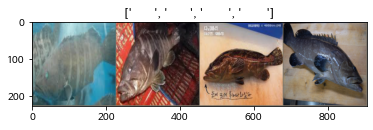

In [ ]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

* 학습할 CNN 딥러닝 모델 객체를 초기화합니다.

In [ ]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

* 학습을 진행합니다.

In [ ]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#0 Loss: 0.7702 Acc: 74.7212% Time: 11.5052s
#1 Loss: 0.2680 Acc: 89.9628% Time: 22.2522s
#2 Loss: 0.1931 Acc: 92.9368% Time: 32.9456s
#3 Loss: 0.0903 Acc: 97.0260% Time: 43.7869s
#4 Loss: 0.1205 Acc: 96.2825% Time: 54.5010s
#5 Loss: 0.1342 Acc: 95.5390% Time: 65.2630s
#6 Loss: 0.0214 Acc: 99.6283% Time: 76.0877s
#7 Loss: 0.1562 Acc: 96.2825% Time: 86.9376s
#8 Loss: 0.0470 Acc: 97.7695% Time: 97.7804s
#9 Loss: 0.0430 Acc: 98.8848% Time: 108.4836s
#10 Loss: 0.0433 Acc: 99.6283% Time: 119.2217s
#11 Loss: 0.0737 Acc: 98.1413% Time: 130.1832s
#12 Loss: 0.0569 Acc: 98.1413% Time: 141.0386s
#13 Loss: 0.0540 Acc: 98.8848% Time: 151.7945s
#14 Loss: 0.0698 Acc: 98.1413% Time: 162.5882s
#15 Loss: 0.0842 Acc: 98.5130% Time: 173.4384s
#16 Loss: 0.0479 Acc: 99.2565% Time: 184.3414s
#17 Loss: 0.0641 Acc: 98.8848% Time: 195.0282s
#18 Loss: 0.0242 Acc: 99.2565% Time: 205.7837s
#19 Loss: 0.0317 Acc: 99.6283% Time: 216.6463s
#20 Loss: 0.0469 Acc: 98.1413% Time: 227.5406s
#21 Loss: 0.0119 Acc: 100.0000% 

* 학습된 모델을 평가합니다.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[예측 결과: 다금바리] (실제 정답: 다금바리)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4355 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4535 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4359 missing from current font.
  font.set_text(s

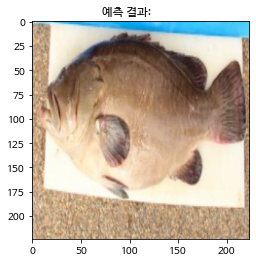

[예측 결과: 다금바리] (실제 정답: 다금바리)


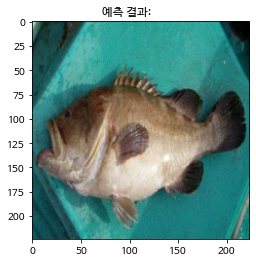

[예측 결과: 다금바리] (실제 정답: 다금바리)


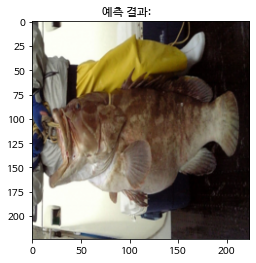

[예측 결과: 다금바리] (실제 정답: 능성어)


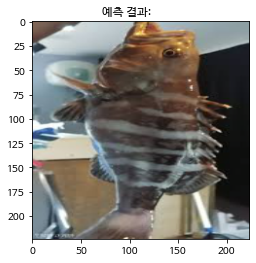

[예측 결과: 다금바리] (실제 정답: 다금바리)


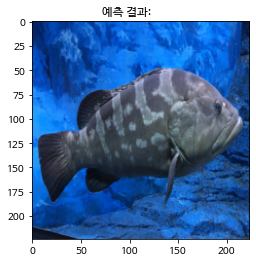

[예측 결과: 물고기] (실제 정답: 물고기)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4462 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4527 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 4358 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 4462 missing from current font.
  font.set_text(s, 

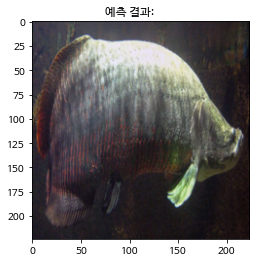

[예측 결과: 능성어] (실제 정답: 능성어)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4453 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4363 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 4354 missing from current font.
  font.set_text(s

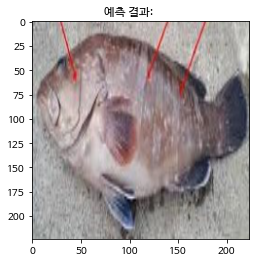

[예측 결과: 다금바리] (실제 정답: 다금바리)


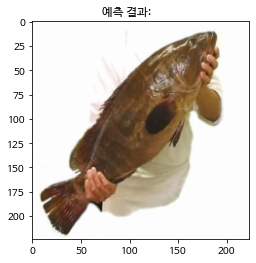

[예측 결과: 다금바리] (실제 정답: 다금바리)


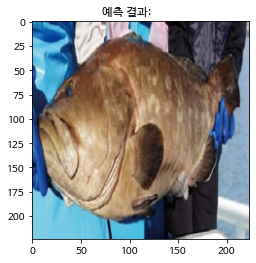

[예측 결과: 다금바리] (실제 정답: 다금바리)


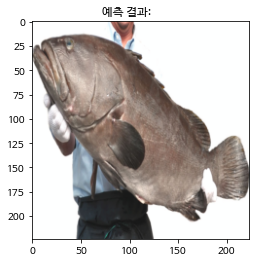

[예측 결과: 다금바리] (실제 정답: 다금바리)


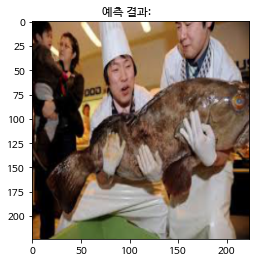

[예측 결과: 다금바리] (실제 정답: 다금바리)


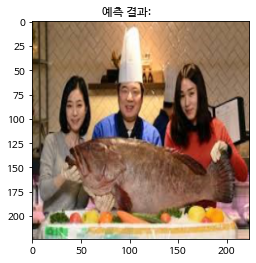

[예측 결과: 능성어] (실제 정답: 능성어)


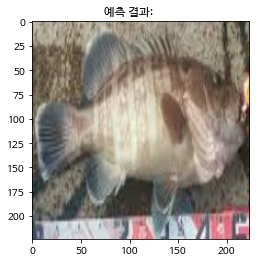

[예측 결과: 다금바리] (실제 정답: 다금바리)


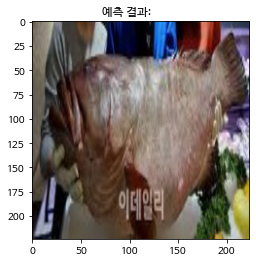

[예측 결과: 능성어] (실제 정답: 능성어)


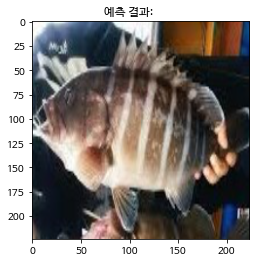

[예측 결과: 능성어] (실제 정답: 능성어)


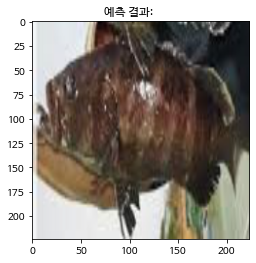

[Test Phase] Loss: 0.0196 Acc: 98.4375% Time: 6.3946s


In [ ]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

#### <b>3. 분류 모델 API 개발</b>

* 학습된 분류 모델을 다른 사람이 사용할 수 있도록 API를 개발하여 배포합니다.
* 먼저 한 장의 이미지를 파일로부터 읽어와 분류 결과를 반환하는 기능을 작성합니다.

In [ ]:
# 테스트용 이미지 다운로드하기
!wget https://namu.wiki/jump/%2B7UtkXJ1u%2FW7EuoumqsDeIyAZ93SCLDW4B2cizSn3eBWhGDELTakuglE5ND%2F%2BSFvoDu%2FIgB9eY%2BVs%2F1fTsjC7w%3D%3D -O test_image.jpg

--2021-12-23 07:48:09--  https://namu.wiki/jump/%2B7UtkXJ1u%2FW7EuoumqsDeIyAZ93SCLDW4B2cizSn3eBWhGDELTakuglE5ND%2F%2BSFvoDu%2FIgB9eY%2BVs%2F1fTsjC7w%3D%3D
Resolving namu.wiki (namu.wiki)... 104.16.180.45, 104.16.181.45, 2606:4700::6810:b52d, ...
Connecting to namu.wiki (namu.wiki)|104.16.180.45|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2021-12-23 07:48:09 ERROR 403: Forbidden.



/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4355 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4467 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4535 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4359 missing from current font.
  font.set_text(s

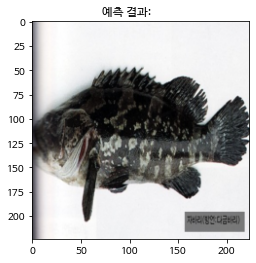

In [ ]:
from PIL import Image


image = Image.open('/content/drive/MyDrive/custom_dataset/test/test_image.jpg')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

* 웹 API 개방을 위해 <b>Ngrok</b> 서비스를 이용합니다.
* API 기능 제공을 위해 <b>Flask 프레임워크</b>를 사용합니다.

In [ ]:
# 필요한 라이브러리 설치하기
!pip install flask-ngrok

In [ ]:
import io
from flask_ngrok import run_with_ngrok
from flask import Flask, jsonify, request


# 이미지를 읽어 결과를 반환하는 함수
def get_prediction(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    image = transforms_test(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
        imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    return class_names[preds[0]]


app = Flask(__name__)


@app.route('/', methods=['POST'])
def predict():
    if request.method == 'POST':
        # 이미지 바이트 데이터 받아오기
        file = request.files['file']
        image_bytes = file.read()

        # 분류 결과 확인 및 클라이언트에게 결과 반환
        class_name = get_prediction(image_bytes=image_bytes)
        print("결과:", {'class_name': class_name})
        return jsonify({'class_name': class_name})

* API를 개방할 수 있으며 실행할 때마다 서버의 주소가 변경됩니다.
* 서버 주소를 정확히 확인할 필요가 있습니다.

In [ ]:
run_with_ngrok(app)
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://4731-35-223-5-115.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


* 클라이언트 테스트 방법

<pre>
curl -X POST -F file=@{이미지 파일명} {Ngrok 서버 주소}
</pre>

* 사용 예시

<pre>
curl -X POST -F file=@dongseok.jpg http://c4cdb8de3a35.ngrok.io/
</pre>

* 이러한 방식으로 웹, 모바일, 게임 등의 소프트웨어 환경에서 API를 호출하는 방식으로 인공지능 앱을 개발할 수 있습니다.